# Stacked Physics-Informed Neural Networks (SPINNs) in Neuromancer

This tutorial demonstrates the use of stacked (multi-fidelity) PINNs for solving partial differential equations (PDEs) in the Neuromancer library.

<img src="../figs/multifidelity_pinn.png" width="1100">  
<!-- <img src="https://github.com/pnnl/neuromancer/tree/feature/multi_fidelity_pinns/examples/figs/multifidelity_pinn.png" width="600">   -->

### References

[1] [Howard, Amanda A., et al. (2023) Stacked networks improve physics-informed training: applications to neural networks and deep operator networks.](https://arxiv.org/abs/2311.06483)

[2] [Heinlein, Alexander, et al. (2023) Multifidelity domain decomposition-based physics-informed neural networks for time-dependent problems.](https://arxiv.org/abs/2401.07888)

## Install (Colab only)
Skip this step when running locally.

In [1]:
# !pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
# !pip install pyDOE

## Imports

In [2]:
# torch and numpy imports
import sys
# import lightning
import torch
import torch.nn as nn
import numpy as np
# data imports
from scipy.io import loadmat
# plotting imports
import matplotlib.pyplot as plt

In [3]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)
#PyTorch random number generator
torch.manual_seed(1234)
# Random number generators in other libraries
np.random.seed(1234)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem Setup

**The 2D steady-state, isotropic diffusion problem** is a classic benchmark problem in heat and mass transfer, where the Laplace equation is solved in a squared domain, under Dirichlet boundary conditions. The problem is given by  

$$ \nabla^2 \boldsymbol{T} = 0. $$

Assuming a two-dimensional space $\Omega = [0,1] \times [0,1]$, the temperature of the plate $T$ varies depending on the spatial position $\boldsymbol{x}$, where $\boldsymbol{x} = [x, y]^T$.

**Boundary Conditions:**

$$T(x, y=1) = T_o,$$
$$T(x=0, y) = T(x=1, y) = T(x, y=0) = 0.$$


## Sample collocation points

In [4]:
# Define number of collocation points in x and y
Nx = 200
Ny = 200

# Define temperature at upper boundary
To = 1.

# Create collocation points
x = torch.linspace(0, 1, Nx).to(device)
y = torch.linspace(0, 1, Ny).to(device)
X, Y = torch.meshgrid(x,y, indexing="ij")
print(X.shape)
print(Y.shape)


torch.Size([200, 200])
torch.Size([200, 200])


### Test data: PDE solution

In [5]:
X_test = X.reshape(-1,1)
Y_test = Y.reshape(-1,1)

##  Construct training datasets

We construct training and development datasets containing [collocation points (CP)](https://en.wikipedia.org/wiki/Collocation_method) of the spatial domain (x,y), and samples of the [boundary conditions (BC)](https://en.wikipedia.org/wiki/Boundary_value_problem).

The dataset is given as:
$\Xi_{\text{train/dev}} = [\texttt{CP}^i, \texttt{BC}^j]$, $i = 1,...,N_{cp}$, $j = 1,...,N_{bp}$  
Where $N_{cp}$ defines number of collocation points, and $N_{bc}$ number of boundary condition samples.

### Samples of Boundary Conditions (BC)

In [6]:
# Initializing the fields
ic_X = X[:, :]
ic_Y = Y[:, :]
ic_T = X[:, :] * 0.
ic_T[:, -1] = 1.

# Left boundary conditions
left_bc_X = X[[0], :]
left_bc_Y = Y[[0], :]
left_bc_T = ic_T[[0], :]

# Right boundary conditions
right_bc_X = X[[-1], :]
right_bc_Y = Y[[-1], :]
right_bc_T = ic_T[[-1], :]

# Top boundary conditions
top_bc_X = X[:, [-1]]
top_bc_Y = Y[:, [-1]]
top_bc_T = ic_T[:, [-1]]

# Bottom boundary conditions
bottom_bc_X = X[:, [0]]
bottom_bc_Y = Y[:, [0]]
bottom_bc_T = ic_T[:, [0]]


### Number of training samples for BC

In [7]:
print(left_bc_X.shape)
print(right_bc_X.shape)
print(top_bc_X.shape)
print(bottom_bc_X.shape)

torch.Size([1, 200])
torch.Size([1, 200])
torch.Size([200, 1])
torch.Size([200, 1])


In [8]:
X_train_bc = torch.concat([left_bc_X.flatten(), right_bc_X.flatten(), top_bc_X.flatten(), bottom_bc_X.flatten()]).view((-1,1))
Y_train_bc = torch.concat([left_bc_Y.flatten(), right_bc_Y.flatten(), top_bc_Y.flatten(), bottom_bc_Y.flatten()]).view((-1,1))
T_train_bc = torch.concat([left_bc_T.flatten(), right_bc_T.flatten(), top_bc_T.flatten(), bottom_bc_T.flatten()]).view((-1,1))
print(X_train_bc.shape, Y_train_bc.shape, T_train_bc.shape)

N_bc = X_train_bc.shape[0]

torch.Size([800, 1]) torch.Size([800, 1]) torch.Size([800, 1])


### Samples of Collocation Points (CP)

In [9]:
# Domain bounds
x_lb = X_test[0]
x_ub = X_test[-1]
y_lb = Y_test[0]
y_ub = Y_test[-1]
print(x_lb, x_ub, y_lb, y_ub)

# Choose (N_collocation) collocation Points to Evaluate the PDE
N_cp = 500
print(f'Number of collocation points for training: {N_cp}')

# Generate collocation points (CP)
X_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(x_lb), float(x_ub)).to(device)
Y_train_cp = torch.FloatTensor(N_cp, 1).uniform_(float(y_lb), float(y_ub)).to(device)
print(X_train_cp.shape, Y_train_cp.shape)

# Append collocation points and boundary points for training
X_train = torch.vstack((X_train_cp, X_train_bc)).float().to(device)
Y_train = torch.vstack((Y_train_cp, Y_train_bc)).float().to(device)
print(X_train.shape, Y_train.shape)

tensor([0.]) tensor([1.]) tensor([0.]) tensor([1.])
Number of collocation points for training: 500
torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([1300, 1]) torch.Size([1300, 1])


### Plot CP and BC points

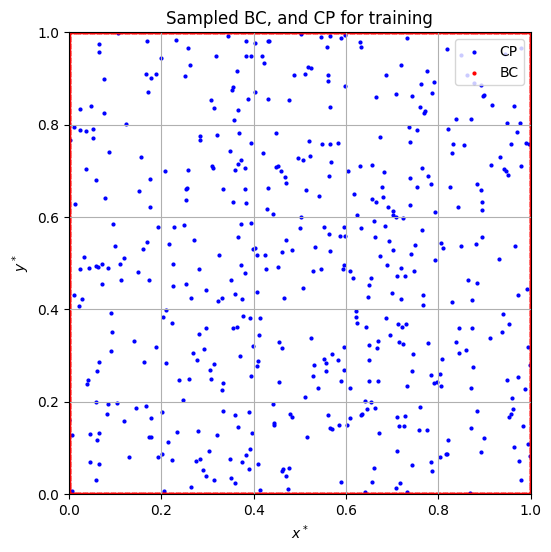

In [10]:
# visualize collocation points for 2D input space (x, y)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X_train_cp.detach().cpu().numpy(), Y_train_cp.detach().cpu().numpy(),
            s=4., c='blue', marker='o', label='CP')
ax.scatter(X_train_bc.detach().cpu().numpy(), Y_train_bc.detach().cpu().numpy(),
            s=4., c='red', marker='o', label='BC')
ax.set_title('Sampled BC, and CP for training')
ax.set_xlim(x_lb.detach().cpu(), x_ub.detach().cpu())
ax.set_ylim(y_lb.detach().cpu(), y_ub.detach().cpu())
ax.grid(True)
ax.set_xlabel('$x^*$')
ax.set_ylabel('$y^*$')
ax.legend(loc='upper right')
ax.set_aspect('equal', 'box')
plt.show()

### Create Neuromancer datasets

In [11]:
from neuromancer.dataset import DictDataset

# turn on gradients for PINN
X_train.requires_grad=True
Y_train.requires_grad=True

# Training dataset
train_data = DictDataset({'x': X_train.to(device), 'y':Y_train.to(device)}, name='train')
# test dataset
test_data = DictDataset({'x': X_test.to(device), 'y':Y_test.to(device)}, name='test')

# torch dataloaders
batch_size = X_train.shape[0]  # full batch training
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         collate_fn=test_data.collate_fn,
                                         shuffle=False)

## PINN Architecture in Neuromancer

### Neural Network Architecture

We will use a Multi-fidelity feed-forward neural network (MultiFidelityMLP) to approximate the PDE solution:
$$\hat{T} = NN_{\theta}(x,y)$$  

In [12]:
from neuromancer.modules import blocks
from neuromancer.system import Node

# Neural net to solve the PDE problem bounded in the PDE domain
# Variables in: x, y; variables out: T
net = blocks.MultiFidelityMLP(
    insize=2,                         # x and y (2 dimensions)
    outsize=1,                        # T(x,y) (1 dimension)
    h_sf_size=[100,100],              # width of hidden layers in single-fidelity net
    n_stacked_mf_layers=3,            # number of stacked nets
    h_linear_sizes=[5,5],             # number of hidden layers in linear stacked nets
    h_nonlinear_sizes=[40, 40],       # number of hidden layers i the nonlinear stacked nets
    nonlin=nn.Tanh,                   # activation function
    freeze_epochs=[2000, 4000, 6000], # freeze the first layer after 1000 epochs, the second layer after 2000 epochs, etc.
    verbose=True
).to(device)

# symbolic wrapper of the multi-fidelity neural net
# Inputs: x and y
# outputs: T
pde_net = Node(net, ['x', 'y'], ['T'], name='net')


In [13]:
print("symbolic inputs  of the pde_net:", pde_net.input_keys)
print("symbolic outputs of the pde_net:", pde_net.output_keys)

symbolic inputs  of the pde_net: ['x', 'y']
symbolic outputs of the pde_net: ['T']


In [14]:
print(f" Total number of parameters = {sum(p.numel() for p in net.parameters())}")
print(net)

 Total number of parameters = 16165
MultiFidelityMLP(
  (alpha): ParameterList(
      (0): Parameter containing: [torch.float32 of size ]
      (1): Parameter containing: [torch.float32 of size ]
      (2): Parameter containing: [torch.float32 of size ]
  )
  (first_layer): MLP(
    (nonlin): ModuleList(
      (0-1): 2 x Tanh()
      (2): Identity()
    )
    (linear): ModuleList(
      (0): Linear(
        (linear): Linear(in_features=2, out_features=100, bias=True)
      )
      (1): Linear(
        (linear): Linear(in_features=100, out_features=100, bias=True)
      )
      (2): Linear(
        (linear): Linear(in_features=100, out_features=1, bias=True)
      )
    )
  )
  (layers): ModuleList(
    (0-2): 3 x ModuleDict(
      (linear): MLP(
        (nonlin): ModuleList(
          (0-2): 3 x Identity()
        )
        (linear): ModuleList(
          (0): Linear(
            (linear): Linear(in_features=1, out_features=5, bias=True)
          )
          (1): Linear(
            (

In [15]:
# Inspect the shape of the weights and biases of the multi-fidelity PINN
print("Multi-fidelity PINN structure:")
for name, param in net.named_parameters():
    print(f"{name}: {param.shape}")


Multi-fidelity PINN structure:
alpha.0: torch.Size([])
alpha.1: torch.Size([])
alpha.2: torch.Size([])
first_layer.linear.0.bias: torch.Size([100])
first_layer.linear.0.weight: torch.Size([100, 2])
first_layer.linear.1.bias: torch.Size([100])
first_layer.linear.1.weight: torch.Size([100, 100])
first_layer.linear.2.bias: torch.Size([1])
first_layer.linear.2.weight: torch.Size([1, 100])
layers.0.linear.linear.0.bias: torch.Size([5])
layers.0.linear.linear.0.weight: torch.Size([5, 1])
layers.0.linear.linear.1.bias: torch.Size([5])
layers.0.linear.linear.1.weight: torch.Size([5, 5])
layers.0.linear.linear.2.bias: torch.Size([1])
layers.0.linear.linear.2.weight: torch.Size([1, 5])
layers.0.nonlinear.linear.0.bias: torch.Size([40])
layers.0.nonlinear.linear.0.weight: torch.Size([40, 3])
layers.0.nonlinear.linear.1.bias: torch.Size([40])
layers.0.nonlinear.linear.1.weight: torch.Size([40, 40])
layers.0.nonlinear.linear.2.bias: torch.Size([1])
layers.0.nonlinear.linear.2.weight: torch.Size([1,

In [16]:
# Test forward pass
net_out = pde_net(train_data.datadict)
print(pde_net(train_data.datadict).keys())
print(pde_net(train_data.datadict)['T'].shape)


dict_keys(['T'])
torch.Size([1300, 1])


###  Define Physics-informed terms

Our neural network approximation  must satisfy the PDE equations  $NN_{\theta}(x,y) \approx T(x,y)$.
Thus we define the physics-informed layers as $f_{\texttt{PINN}}$:

$$f_{\texttt{PINN}}(x,y)=
 \frac{\partial^2 NN_{\theta}(x,y)}{\partial x^2} + \frac{\partial^2 NN_{\theta}(x,y)}{\partial y^2}
 $$

We can obtain the derivatives of the neural net $\frac{\partial^2 NN_{\theta}}{\partial x^2},\frac{\partial^2 NN_{\theta}}{\partial y^2}$ using [Automatic Diferentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).

To simplify the implementation of $f_{\texttt{PINN}}$ we exploit the symbolic variable of the Neuromancer library.

In [17]:
from neuromancer.constraint import variable

# symbolic Neuromancer variables
T = variable('T')  # PDE solution generated as the output of a neural net (pde_net)
x = variable('x')  # spatial coordinate 1
y = variable('y')  # spatial coordinate 2

In [18]:
# get the symbolic derivatives
dT_dx = T.grad(x)
dT_dy = T.grad(y)
d2T_dx2 = dT_dx.grad(x)
d2T_dy2 = dT_dy.grad(y)

# get the PINN form
f_pinn = d2T_dx2 + d2T_dy2

In [19]:
# check the shapes of the forward pass of the symbolic PINN terms
print(d2T_dx2({**net_out, **train_data.datadict}).shape)
print(d2T_dy2({**net_out, **train_data.datadict}).shape)
print(f_pinn({**net_out, **train_data.datadict}).shape)

torch.Size([1300, 1])
torch.Size([1300, 1])
torch.Size([1300, 1])


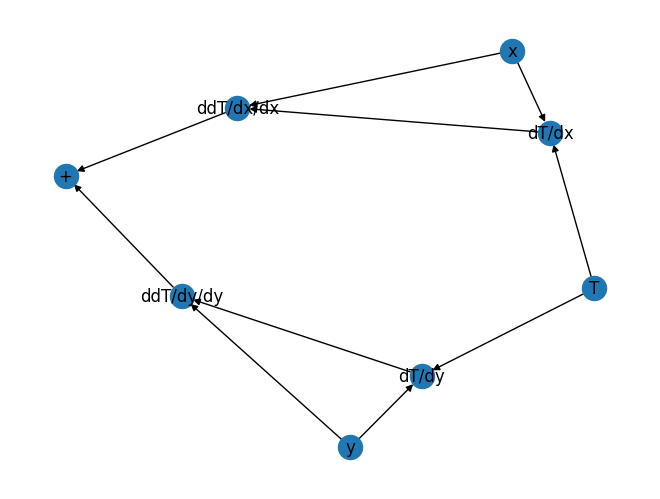

In [20]:
# computational graph of the PINN neural network
f_pinn.show()

### PINNs' Loss function terms

**PDE Collocation Points Loss:**  
We evaluate our PINN $f_{\texttt{PINN}}$ over given number ($N_{cp}$) of collocation points (CP) and minimize the PDE residuals in the following loss function:

$$\ell_{c}=\frac{1}{N_{cp}}\sum^{N_{cp}}_{i=1}|f_{\texttt{PINN}}(x_c^i,y_c^i)|^2$$

If $f_{\texttt{PINN}}\rightarrow 0$ then our PINN converges to the solution of the PDE.

**PDE Boundary Conditions Loss:**

We select $N_{b}$ points from our BC and used them in the following supervised learning loss function:

$$\ell_{b}=\frac{1}{N_{bc}}\sum^{N_{bc}}_{i=1}|T(x_{b}^i,y_b^i)-NN_{\theta}(t_{b}^i,x_b^i)|^2$$

#### Total Loss:
The total loss is just a sum of PDE residuals over CP and supervised learning residuals over BC.

$$\ell_{\text{PINN}}=\ell_{cp}+\ell_{bc}$$
<!-- $$\ell_{\text{PINN}}=\ell_{f}+\ell_{u} +\ell_{y}$$ -->

In [21]:
# scaling factor for better convergence
scaling_cp = 1.
scaling_bc = 10.

# PDE CP loss (MSE)
l_cp = scaling_cp*(f_pinn == torch.tensor(0.).to(device))^2

# PDE BC loss (MSE)
l_bc = scaling_bc*( T[-N_bc:] - T_train_bc == torch.tensor(0.).to(device) )^2 # remember that we concatenated CP and BC

# output constraints to bound the PINN solution
con_1 = (T >= 0) #Passive scalar T is always positive; note: this is optional

##  Train the PINN to solve the PDE

We use stochastic gradient descent to optimize the parameters $\theta$ of the neural network $NN_{\theta}(x,y)$ approximating the solution to the PDE equation $y(t,x)$ using the PINN loss $\ell_{\text{PINN}}$ evaluated over sampled CP and BC.

### Define the optimization problem in Neuromancer

In [22]:
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem

# Multi-fidelity loss
loss = PenaltyLoss(objectives=[l_cp, l_bc], constraints=[con_1])

# Construct the PINN optimization problem
problem = Problem(nodes=[pde_net],       # list of nodes (neural nets) to be optimized
                   loss=loss,         # physics-informed loss function
                   grad_inference=True   # argument for allowing computation of gradients at the inference time
                  )


### Construct Trainer and solve the problem  

In [23]:
from neuromancer.trainer import Trainer

optimizer = torch.optim.AdamW(problem.parameters(), lr=1e-3)

epochs = 10000

#  Neuromancer trainer
trainer = Trainer(
    problem.to(device),
    train_loader,
    optimizer=optimizer,
    epochs=epochs,
    epoch_verbose=200,
    train_metric='train_loss',
    dev_metric='train_loss',
    eval_metric="train_loss",
    warmup=epochs,
    multi_fidelity=True,
    device=device
)


In [24]:
# Train PINN
best_model = trainer.train()

# load best trained model
problem.load_state_dict(best_model)

/Users/pere066/Projects/neuromancer_mfpinn_integration/.venv/lib/python3.10/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)
/Users/pere066/Projects/neuromancer_mfpinn_integration/.venv/lib/python3.10/site-packages/neuromancer/constraint.py:172: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([800, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(left, right)


epoch: 0  train_loss: 3.753767251968384
epoch: 200  train_loss: 0.77521151304245
epoch: 400  train_loss: 0.3381493091583252
epoch: 600  train_loss: 0.24988950788974762
epoch: 800  train_loss: 0.23342953622341156
epoch: 1000  train_loss: 0.22786208987236023
epoch: 1200  train_loss: 0.22255055606365204
epoch: 1400  train_loss: 0.2211921662092209
epoch: 1600  train_loss: 0.2154415100812912
epoch: 1800  train_loss: 0.21391555666923523
Single-fidelity (0th layer) parameters have been frozen
Now training stacked block 1
epoch: 2000  train_loss: 0.21147269010543823
epoch: 2200  train_loss: 0.2656000554561615
epoch: 2400  train_loss: 0.2128414660692215
epoch: 2600  train_loss: 0.2109074741601944
epoch: 2800  train_loss: 0.21030668914318085
epoch: 3000  train_loss: 0.21009162068367004
epoch: 3200  train_loss: 0.21002022922039032
epoch: 3400  train_loss: 0.2099684774875641
epoch: 3600  train_loss: 0.20992113649845123
epoch: 3800  train_loss: 0.2098759412765503
Multi-fidelity (layer 1) parameters

<All keys matched successfully>

In [25]:
# Verify that final parameter alpha is small (see Eq. 11 of Howard, Amanda A. et al. 2023).
for idx,alpha in enumerate(net.alpha):
    print(f"alpha_{idx} = {alpha}")


alpha_0 = Parameter containing:
tensor(0.0763, requires_grad=True)
alpha_1 = Parameter containing:
tensor(0.0706, requires_grad=True)
alpha_2 = Parameter containing:
tensor(0.2876, requires_grad=True)


In [26]:
# Evaluate trained PINN on test data (all the data in the domain)
PINN = problem.nodes[0]
T_pinn = PINN(test_data.datadict)['T']

# arrange data for plotting
T_pinn = T_pinn.reshape(shape=[Nx,Ny]).detach().cpu()


### Plots

## Compute the error and plot solutions
We can compare the estimated result $\hat{T}^*$ with the analytical solution $T_{exact}^*$:

$$T_{exact}^{*} (x^*,y^*) = \sum_{k=1}^{\infty} \frac{2 T_o [1-(-1)^k]}{k \pi} \frac{\sin(k\pi x^*) \sinh(k \pi y^*)} {\sinh(k \pi)}$$

For evaluation purposes and to avoid numerical overflow, we truncate the series solution to $N = 200$ modes.

In [27]:
# Compute the analytical solution
T_exact = np.zeros(shape=(Nx,Ny))
N_modes = 200
To = 1
x_ = np.linspace(0, 1, Nx)
y_ = np.linspace(0, 1, Ny)

for k in range(1,N_modes):
    for i in range(Nx):
        for j in range(Ny):
            T_exact[i,j] += 2 * To * (1-(-1)**k) * np.sin(k*np.pi*x_[i]) * np.sinh(k*np.pi*y_[j])/(k*np.pi * np.sinh(k*np.pi))


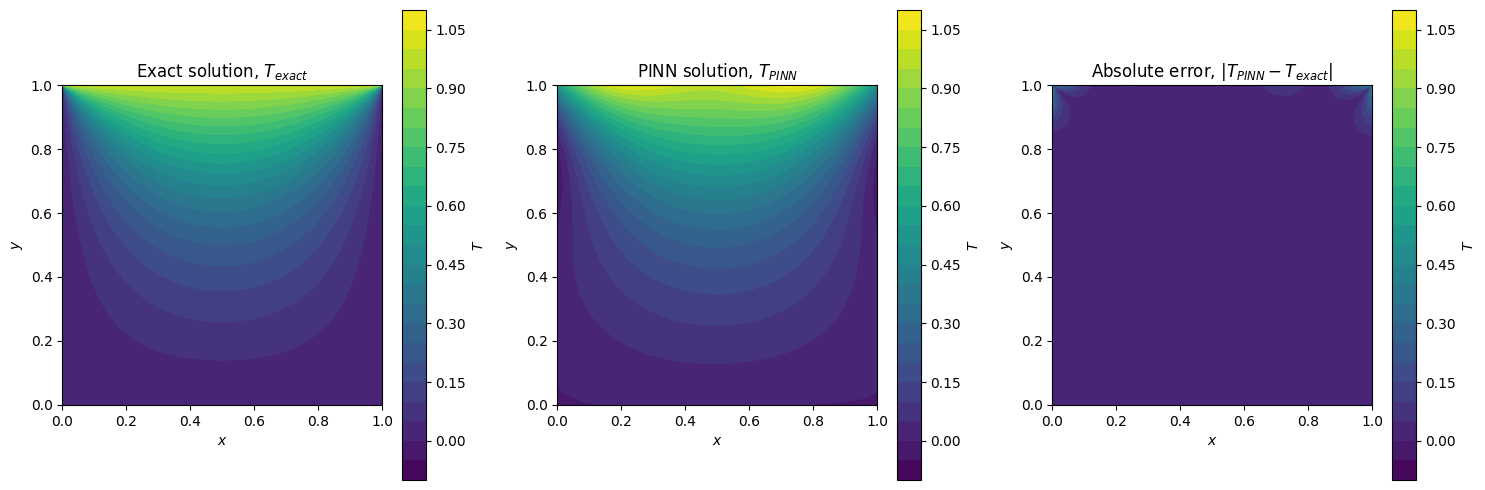

In [28]:
# Plot 3 contour plots (T_exact vs T_pinn vs |T_exact - T_pinn|)
plt.figure(figsize=(15, 5))  # Increase figure size for better visibility

# Plot for the first heatmap (Exact solution)
ax1 = plt.subplot(1, 3, 1)
cbarticks = np.arange(-0.1,1.1,0.05)
CP1 = plt.contourf(ic_X, ic_Y, T_exact, cbarticks, cmap='viridis')
plt.title('Exact solution, $T_{exact}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP1, label='$T$')
ax1.set_aspect('equal', adjustable='box')

# # Plot for the second heatmap (PINN solution)
ax2 = plt.subplot(1, 3, 2)
CP2 = plt.contourf(ic_X, ic_Y, T_pinn, cbarticks, cmap='viridis')
plt.title('PINN solution, $T_{PINN}$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP2, label='$T$')
ax2.set_aspect('equal', adjustable='box')

# Plot absolute error between PINN approximation and exact solution
ax3 = plt.subplot(1, 3, 3)
CP3 = plt.contourf(ic_X, ic_Y, torch.abs(torch.Tensor(T_exact)-T_pinn),cbarticks, cmap='viridis')
plt.title('Absolute error, $|T_{PINN} - T_{exact}|$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(CP3, label='$T$')
ax3.set_aspect('equal', adjustable='box')

plt.tight_layout()  # Adjusts subplot params so that the subplots fit into the figure area
plt.show()


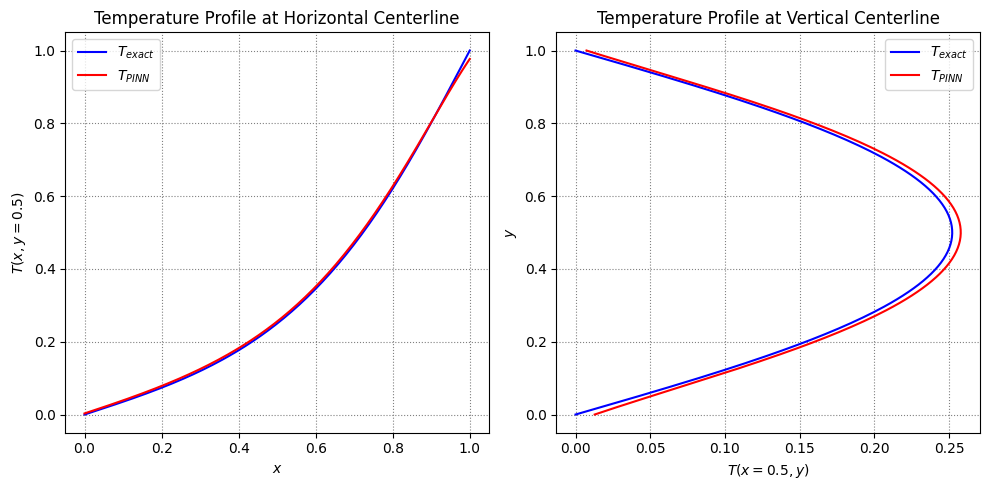

In [29]:
# Calculate the horizontal centerline (middle row) for both datasets
horizontal_centerline_T_exact = T_exact[T_exact.shape[0] // 2, :]
horizontal_centerline_T_pinn = T_pinn[T_pinn.shape[0] // 2, :]

# Calculate the vertical centerline (middle column) for both datasets
vertical_centerline_T_exact = T_exact[:, T_exact.shape[1] // 2]
vertical_centerline_T_pinn = T_pinn[:, T_pinn.shape[1] // 2]

# Create a figure and axis for the plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Temperature at the horizontal centerline vs. x values
ax[0].plot(x_, horizontal_centerline_T_exact, color='blue', label='$T_{exact}$')
ax[0].plot(x_, horizontal_centerline_T_pinn, color='red', label='$T_{PINN}$')
ax[0].set_title('Temperature Profile at Horizontal Centerline')
ax[0].set_xlabel('$x$')
ax[0].set_ylabel('$T(x,y=0.5)$')
ax[0].grid(True, linestyle=':', color='gray')  # Add dotted grid
ax[0].legend()

# Plot 2: Temperature at the vertical centerline vs. y values
ax[1].plot(vertical_centerline_T_exact, y_, color='blue', label='$T_{exact}$')
ax[1].plot(vertical_centerline_T_pinn, y_, color='red', label='$T_{PINN}$')
ax[1].set_title('Temperature Profile at Vertical Centerline')
ax[1].set_xlabel('$T(x=0.5, y)$')
ax[1].set_ylabel('$y$')
ax[1].grid(True, linestyle=':', color='gray')  # Add dotted grid
ax[1].legend()

plt.tight_layout()
plt.show()


